<a href="https://colab.research.google.com/github/paulynamagana/af3_report/blob/main/AFserver_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Plotting AlphaFold Results


In [3]:
#@markdown  Run this cell to upload the zip file
import zipfile
import os
from google.colab import files
import shutil

# Get the current directory
current_dir = '/content/'

# Loop through the files and delete them
for filename in os.listdir(current_dir):
    file_path = os.path.join(current_dir, filename)
    if os.path.isfile(file_path):
        os.remove(file_path)
    elif os.path.isdir(file_path):
        shutil.rmtree(file_path)

uploaded = files.upload()

filename = list(uploaded.keys())[0]

with zipfile.ZipFile(filename, 'r') as zip_ref:
       zip_ref.extractall('unzipped_files')

Saving fold_protein_dna_kat6a.zip to fold_protein_dna_kat6a.zip


In [4]:
#@markdown  Run this cell to get the pae plots
import json
import numpy as np
import matplotlib.pyplot as plt
import argparse
from pathlib import Path
import glob
import os
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
from matplotlib.patches import Rectangle
from matplotlib.cm import get_cmap
from matplotlib.lines import Line2D


def load_data_from_json(json_path):
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)

        pae_matrix = np.array(data.get("pae", []))
        plddt_scores = data.get("atom_plddts", [])
        token_chain_ids = data.get("token_chain_ids", [])
        token_res_ids = data.get("token_res_ids", [])
        contact_proba_data = np.array(data.get("contact_probs", []))

        if pae_matrix.size == 0 or not plddt_scores:
            raise ValueError("Missing required keys ('pae', 'plddt') in JSON file.")

        return pae_matrix, plddt_scores, token_chain_ids, token_res_ids, contact_proba_data
    except (FileNotFoundError, json.JSONDecodeError, KeyError, ValueError) as e:
        print(f"Error loading JSON file: {e}")
        return None, None, None, None, None, None



def plot_matrix(matrix, type_matrix, ax=None):
    """
    Plot the PAE matrix on the given axis.

    Parameters:
    - pae_matrix: 2D NumPy array of PAE values.
    - ax: Matplotlib axis object, optional. If None, a new axis is created.

    Returns:
    - ax: Matplotlib axis object with the plot.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 12))
    if type_matrix == "PAE":
        ax.set_facecolor("white")
        cmap = ax.imshow(
            matrix,
            vmin=0,
            vmax=32,
            cmap="Greens_r"
        )
        ax.set_xlabel("Scored Residue")
        ax.set_ylabel("Aligned Residue")
        return ax, cmap
    if type_matrix == "contact":
        cmap = ax.imshow(
            matrix,
            vmin=0,
            vmax=1,
            cmap="viridis"
        )
        ax.set_xlabel("Residue i")
        ax.set_ylabel("Residue j")
        return ax, cmap


def add_chain_boundaries(token_chain_ids, token_res_ids, ax):
    """
    Add chain boundaries and labels using token_chain_ids and token_res_ids.

    Parameters:
    - token_chain_ids: list of chain IDs for each token.
    - token_res_ids: list of residue numbers for each token.
    - ax: Matplotlib axis object.
    """
    chain_ranges = []
    current_chain = None
    start = 0

    for i, (chain_id, res_id) in enumerate(zip(token_chain_ids, token_res_ids)):
        if current_chain is None:
            current_chain = chain_id

        if chain_id != current_chain or i == len(token_chain_ids) - 1:
            end = i - 1 if i == len(token_chain_ids) - 1 else i
            chain_ranges.append((current_chain, start, end))
            current_chain = chain_id
            start = i


    # Define a color palette with enough colors for all chains
    # Define the number of chains
    num_chains = len(chain_ranges)

    # Choose a colormap with enough colors
    if num_chains <= 10:
        color_palette = colormaps["tab10"]  # A colormap with 10 colors
    elif num_chains <= 20:
        color_palette = colormaps["tab10"]  # A colormap with 20 colors
    else:
        color_palette = colormaps["tab10"]   # A colormap with a larger range of colors

    # Generate colors for each chain
    colors = [color_palette(i / num_chains) for i in range(num_chains)]


    # Create custom legend entries
    legend_elements = []

    for idx, (chain_id, start, end) in enumerate(chain_ranges):
        ax.axhline(y=start, color="black", linestyle="--", linewidth=1)
        ax.axvline(x=start, color="black", linestyle="--", linewidth=1)
        ax.axhline(y=end, color="black", linestyle="--", linewidth=1)
        ax.axvline(x=end, color="black", linestyle="--", linewidth=1)

        # Calculate mid position
        mid_pos = (start + end) / 2
        ax.text(mid_pos, -40, chain_id, ha="center", fontsize=10, color="black")

        # Select a color for the chain
        color = color_palette(idx % color_palette.N)  # Handle more chains than available colors
        # Draw the chain bottom border with the selected color
        ax.plot([start, end], [-20, -20], color=color, linewidth=2)

        # Create legend entry for this chain
        legend_elements.append(Line2D([0], [0], color=color, lw=2, label=f"Chain {chain_id}"))

        ax.text(-45, mid_pos, chain_id, ha="center", fontsize=10, color="black", rotation=90)
        ax.plot([-15, -15], [start, end], color=color, linewidth=2)
        ax.tick_params(axis='both', which='major', pad=10)


def plot_combined(pae_matrix, plddt_scores, token_chain_ids, token_res_ids, output_dir, json_file_name, contact_proba_data):
    """
    Plot combined pLDDT, PAE, and Contact Probability in a single figure and save as a PNG file.

    Parameters:
    - pae_matrix: 2D NumPy array of PAE values.
    - plddt_scores: list of pLDDT scores.
    - token_chain_ids: list of chain IDs for each token.
    - token_res_ids: list of residue IDs for each token.
    - output_dir: str, directory to save the plot.
    - json_file_name: str, base name of the plot file.
    - contact_proba_data: 2D NumPy array of contact probability values.
    """
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(2, 2, height_ratios=[0.4, 1], width_ratios=[1, 1])

    # Plot pLDDT
    ax1 = fig.add_subplot(gs[0, :])
    total_residues = len(plddt_scores)
    ax1.add_patch(Rectangle((0, 90), total_residues, 10, color="#024fcc", alpha=0.3, label="Very high (pLDDT > 90)"))
    ax1.add_patch(Rectangle((0, 70), total_residues, 20, color="#60c2e8", alpha=0.3, label="High (90 > pLDDT > 70)"))
    ax1.add_patch(Rectangle((0, 50), total_residues, 20, color="#f37842", alpha=0.3, label="Low (70 > pLDDT > 50)"))
    ax1.add_patch(Rectangle((0, 0), total_residues, 50, color="#f9d613", alpha=0.3, label="Very low (pLDDT < 50)"))
    sns.lineplot(x=np.arange(1, total_residues + 1), y=plddt_scores, ax=ax1, color="black", linewidth=0.3)
    ax1.set_xlabel("Residue")
    ax1.set_ylabel("pLDDT Score")
    ax1.set_ylim(0, 100)
    ax1.set_title("Predicted Local Distance Difference Test (pLDDT) Scores")
    ax1.legend(title="pLDDT confidence", loc="upper left", bbox_to_anchor=(1, 1))
    ax1.spines[["right", "top"]].set_visible(False)
    ax1.set_xlim(0, total_residues + 1)  # Ensure x-axis matches residue range
    ax1.margins(0)  # Disable any additional margins

    # Plot PAE
    ax2 = fig.add_subplot(gs[1, 0])
    ax2, cmap = plot_matrix(pae_matrix, "PAE", ax2)
    add_chain_boundaries(token_chain_ids, token_res_ids, ax2)
    fig.colorbar(cmap, ax=ax2, orientation="vertical", label="Expected Position Error (Å)", shrink=0.5)
    ax2.set_title("Predicted Aligned Error (PAE) Matrix", pad=20)

    # Plot Contact Probability Matrix
    ax3 = fig.add_subplot(gs[1, 1])
    ax3, cmap = plot_matrix(contact_proba_data, "contact", ax3)
    add_chain_boundaries(token_chain_ids, token_res_ids, ax3)
    fig.colorbar(cmap, ax=ax3, orientation="vertical", label="Predicted contact", shrink=0.5)
    ax3.set_title("Contact Probability Matrix")
    ax3.set_xlabel("Residue i")
    ax3.set_ylabel("Residue j")

    # Adjust spacing and layout
    plt.tight_layout()

    # Save the plot
    output_file = Path(output_dir) / f"{json_file_name}_combined.png"
    plt.savefig(output_file, dpi=300, bbox_inches="tight")
    plt.close()
    print(f"Combined plot saved to {output_file}")



def process_folder(folder_path, output_dir):
    """
    Process all JSON files in the folder matching the pattern *full_data_*.json.

    Parameters:
    - folder_path: str, path to the folder containing JSON files.
    - output_dir: str, path to save the plots.
    """
    json_files = glob.glob(f"{folder_path}/*full_data_*.json")
    if not json_files:
        print(f"No matching JSON files found in folder: {folder_path}")
        return

    Path(output_dir).mkdir(parents=True, exist_ok=True)

    for json_file in json_files:
        print(f"Processing file: {json_file}")
        pae_matrix, plddt_scores, token_chain_ids, token_res_ids, contact_proba_data = load_data_from_json(json_file)
        if pae_matrix is not None:
            json_file_name = Path(json_file).stem
            plot_combined(pae_matrix, plddt_scores, token_chain_ids, token_res_ids, output_dir, json_file_name, contact_proba_data)



# Google Colab entry point
def main():
    folder_path = "/content/unzipped_files"  # Modify this path to your folder
    output_dir = "outputs"  # Folder to store the plots
    process_folder(folder_path, output_dir)

# Run the function in Colab
main()


Processing file: /content/unzipped_files/fold_protein_dna_kat6a_full_data_3.json


<ipython-input-4-16a9a8ccf217>:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = get_cmap("tab10")  # A colormap with 10 colors


Combined plot saved to outputs/fold_protein_dna_kat6a_full_data_3_combined.png
Processing file: /content/unzipped_files/fold_protein_dna_kat6a_full_data_0.json


<ipython-input-4-16a9a8ccf217>:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = get_cmap("tab10")  # A colormap with 10 colors


Combined plot saved to outputs/fold_protein_dna_kat6a_full_data_0_combined.png
Processing file: /content/unzipped_files/fold_protein_dna_kat6a_full_data_2.json


<ipython-input-4-16a9a8ccf217>:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = get_cmap("tab10")  # A colormap with 10 colors


Combined plot saved to outputs/fold_protein_dna_kat6a_full_data_2_combined.png
Processing file: /content/unzipped_files/fold_protein_dna_kat6a_full_data_1.json


<ipython-input-4-16a9a8ccf217>:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = get_cmap("tab10")  # A colormap with 10 colors


Combined plot saved to outputs/fold_protein_dna_kat6a_full_data_1_combined.png
Processing file: /content/unzipped_files/fold_protein_dna_kat6a_full_data_4.json


<ipython-input-4-16a9a8ccf217>:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = get_cmap("tab10")  # A colormap with 10 colors


Combined plot saved to outputs/fold_protein_dna_kat6a_full_data_4_combined.png


In [5]:
#@markdown  Run this cell to generate report

!pip install reportlab

from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
import json
import glob
import string

def generate_alphafold_pdf_report(folder_path, output_pdf_path):
    # Load the JSON file
    json_files = glob.glob(f"{folder_path}/*job_request.json")
    if not json_files:
        print(f"No matching JSON file found in folder: {folder_path}")
        return

    json_file = json_files[0]  # Select the first file from the list

    with open(json_file, 'r') as file:
      data = json.load(file)

    # Function to generate chain labels based on the count starting from the given index
    def generate_chain_labels(start_index, count):
        """Generate chain labels based on the count starting from the given index."""
        labels = []
        alphabet = string.ascii_uppercase
        for i in range(count):
            label = ''
            n = start_index + i
            while n >= 0:
                label = alphabet[n % 26] + label
                n = n // 26 - 1
            labels.append(label)
        return labels

    # Assign labels and add to each sequence
    last_used_index = 0
    for entry in data:
        for sequence in entry["sequences"]:
            if "proteinChain" in sequence:
                seq = sequence["proteinChain"]
                chain_labels = generate_chain_labels(last_used_index, seq['count'])
                # Assign the labels to the sequence
                sequence["chainLabels"] = chain_labels
                last_used_index += seq['count']
            elif "dnaSequence" in sequence:
                seq = sequence["dnaSequence"]
                chain_labels = generate_chain_labels(last_used_index, seq['count'])
                # Assign the labels to the sequence
                sequence["chainLabels"] = chain_labels
                last_used_index += seq['count']

    # Initialize the PDF canvas
    pdf = canvas.Canvas(output_pdf_path, pagesize=letter)
    width, height = letter

    # Font settings
    pdf.setFont("Helvetica", 10)
    margin = 50
    line_spacing = 14
    y_position = height - margin  # Start near the top of the page

    # Maximum width for text wrapping
    max_line_length = 60  # Maximum number of characters per line for sequences

    def wrap_long_text(text, max_length):
        """Split text into lines of specified max length."""
        return [text[i:i + max_length] for i in range(0, len(text), max_length)]

    for entry in data:
        # Entry title
        pdf.setFont("Helvetica-Bold", 12)
        pdf.drawString(margin, y_position, f"{entry['name']}")
        y_position -= line_spacing

        pdf.setFont("Helvetica", 10)

        # Print model seeds
        model_seeds = "Model Seeds: " + ", ".join(entry["modelSeeds"])
        pdf.drawString(margin, y_position, model_seeds)
        y_position -= line_spacing

        # Print sequence details
        pdf.drawString(margin, y_position, "Sequences:")
        y_position -= line_spacing

        for sequence in entry["sequences"]:
            # Print chain labels and sequence details
            chain_labels = ", ".join(sequence["chainLabels"])
            if "proteinChain" in sequence:
                seq = sequence["proteinChain"]
                y_position -= line_spacing
                header = f"Protein Sequence Chains {chain_labels} (Count = {seq['count']}, Length = {len(seq['sequence'])}):"
                pdf.drawString(margin + 20, y_position, header)
                y_position -= line_spacing

                # Wrap and print the sequence
                sequence_lines = wrap_long_text(seq["sequence"], max_line_length)
                for line in sequence_lines:
                    pdf.drawString(margin + 40, y_position, line)
                    y_position -= line_spacing

            elif "dnaSequence" in sequence:
                seq = sequence["dnaSequence"]
                y_position -= line_spacing
                header = f"DNA Sequence Chains {chain_labels} (Count = {seq['count']}, Length = {len(seq['sequence'])}):"
                pdf.drawString(margin + 20, y_position, header)
                y_position -= line_spacing

                # Wrap and print the sequence
                sequence_lines = wrap_long_text(seq["sequence"], max_line_length)
                for line in sequence_lines:
                    pdf.drawString(margin + 40, y_position, line)
                    y_position -= line_spacing

            # Check if we need a new page
            if y_position < margin:
                pdf.showPage()
                pdf.setFont("Helvetica", 10)
                y_position = height - margin

        # Add space between entries
        y_position -= line_spacing
        if y_position < margin:
            pdf.showPage()
            pdf.setFont("Helvetica", 10)
            y_position = height - margin

    # Save the PDF
    pdf.save()
    print(f"PDF report generated and saved to {output_pdf_path}")
# Example usage
json_file_path = "/content/unzipped_files"  # Replace with your JSON file path
output_pdf_path = "/content/outputs/alphafold3_report.pdf"   # Replace with your desired PDF file path
generate_alphafold_pdf_report(json_file_path, output_pdf_path)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.2 MB/s eta 0:00:00
PDF report generated and saved to /content/outputs/alphafold3_report.pdf


In [6]:
#@markdown  Run this cell to generate summary iptms and ptm

import json
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from pathlib import Path
import argparse
from matplotlib.table import Table
from matplotlib import colormaps
from matplotlib.gridspec import GridSpec

def load_data_from_json(json_path):
    """
    Load chain iptm data and other metrics from a JSON file.

    Parameters:
    - json_path: str, path to the JSON file.

    Returns:
    - chain_iptm_data: 2D NumPy array of chain iptm values.
    - metrics: Dictionary containing the values for "fraction_disordered", "has_clash",
               "iptm", "num_recycles", "ptm", and "ranking_score".
    """
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)

        chain_iptm_data = np.array(data['chain_iptm'])
        chain_ptm_data = np.array(data['chain_ptm'])

        return chain_iptm_data, chain_ptm_data
    except (FileNotFoundError, json.JSONDecodeError, KeyError) as e:
        print(f"Error loading JSON file: {e}")
        return None, None



def plot_boxplot(data, title, labels, output_dir, filename):
    """
    Create a boxplot of the aggregated data and save it.

    Parameters:
    - data: List of 1D NumPy arrays containing the chain data (either IPTM or PTM).
    - title: Title of the boxplot.
    - labels: List of labels corresponding to the data.
    - output_dir: str, directory to save the plot.
    - filename: Name of the file to save the plot as.
    """
    # Create a figure for the boxplot
    fig, ax = plt.subplots(figsize=(10, 6))

    num_chains = len(labels)

    # Choose a colormap with enough colors
    if num_chains <= 10:
        color_palette = colormaps["tab10"]  # A colormap with 10 colors
    elif num_chains <= 20:
        color_palette = colormaps["tab20"] # A colormap with 20 colors
    else:
        color_palette = colormaps["tab20c" ] # A colormap with a larger range of colors

        # Generate colors for each chain
    colors = [color_palette(i / num_chains) for i in range(num_chains)]


    # Plot the boxplot
    sns.boxplot(data=data, ax=ax, palette=colors)
    sns.stripplot(data=data, size=4, color=".3")

    # Set the labels and title
    ax.set_xticklabels(labels)
    ax.set_title(title)
    ax.set_ylabel('Values')
    ax.spines[["right", "top"]].set_visible(False)

    # Save the plot
    output_file = os.path.join(output_dir, filename)
    plt.savefig(output_file)
    plt.close()


def process_folder(folder_path, output_dir):
    """
    Process all JSON files in the folder matching the pattern *summary_confidences_*.json,
    aggregate data, and plot a boxplot for each dataset (chain_iptm_data and chain_ptm_data).

    Parameters:
    - folder_path: str, path to the folder containing JSON files.
    - output_dir: str, path to save the plots.
    """
    json_files = glob.glob(f"{folder_path}/*summary_confidences_*.json")
    if not json_files:
        print(f"No matching JSON files found in folder: {folder_path}")
        return

    # Create the output directory if it doesn't exist
    Path(output_dir).mkdir(parents=True, exist_ok=True)

    # Initialize lists to store data for each chain (per chain, aggregated across files)
    aggregated_chain_iptm_data = []
    aggregated_chain_ptm_data = []
    all_labels = []

    # Iterate over each JSON file
    for json_file in json_files:
        json_file_name = Path(json_file).stem
        print(f"Processing file: {json_file}")

        chain_iptm_data, chain_ptm_data = load_data_from_json(json_file)

        if chain_iptm_data is not None and chain_ptm_data is not None:
            # Create labels for the chains (using the length of the data)
            labels = [chr(i) for i in range(65, 65 + len(chain_iptm_data))]  # Corrected for 1D data
            all_labels = labels  # Assuming labels are consistent across all files

            # Append each chain's data across all files (aggregating by chain)
            if not aggregated_chain_iptm_data:
                # Initialize the aggregated lists with empty lists for each chain
                aggregated_chain_iptm_data = [[] for _ in range(len(chain_iptm_data))]
                aggregated_chain_ptm_data = [[] for _ in range(len(chain_ptm_data))]

            # Aggregate the data for each chain (column-wise)
            for i in range(len(chain_iptm_data)):
                aggregated_chain_iptm_data[i].append(chain_iptm_data[i])
                aggregated_chain_ptm_data[i].append(chain_ptm_data[i])
        else:
            print(f"Skipping file due to error: {json_file}")

    if aggregated_chain_iptm_data and aggregated_chain_ptm_data:
        # Now plot separate boxplots for chain_iptm_data and chain_ptm_data
        plot_boxplot(aggregated_chain_iptm_data, 'Chain IPTM Data', all_labels, output_dir, 'chain_iptm_data.png')
        plot_boxplot(aggregated_chain_ptm_data, 'Chain PTM Data', all_labels, output_dir, 'chain_ptm_data.png')
    else:
        print("No valid data to plot.")



def main():
    json_file_path = "/content/unzipped_files"  # Replace with your JSON file path
    output_dir = "/content/outputs/"   # Replace with your desired PDF file path

    # Process all matching JSON files in the folder
    process_folder(json_file_path, output_dir)


main()



Processing file: /content/unzipped_files/fold_protein_dna_kat6a_summary_confidences_1.json
Processing file: /content/unzipped_files/fold_protein_dna_kat6a_summary_confidences_4.json
Processing file: /content/unzipped_files/fold_protein_dna_kat6a_summary_confidences_2.json
Processing file: /content/unzipped_files/fold_protein_dna_kat6a_summary_confidences_3.json
Processing file: /content/unzipped_files/fold_protein_dna_kat6a_summary_confidences_0.json


<ipython-input-6-a54e510ad3d1>:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
<ipython-input-6-a54e510ad3d1>:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


Processing file: /content/unzipped_files/fold_protein_dna_kat6a_summary_confidences_1.json


<ipython-input-7-c95cf20a079b>:109: MatplotlibDeprecationWarning: 'col' must be an int or sequence of ints. Passing other types is deprecated since 3.8 and will be removed two minor releases later.
  table.auto_set_column_width([0.5, 0.5])


Combined plot saved to /content/outputs/fold_protein_dna_kat6a_summary_confidences_1_summary.png
Processing file: /content/unzipped_files/fold_protein_dna_kat6a_summary_confidences_4.json


<ipython-input-7-c95cf20a079b>:109: MatplotlibDeprecationWarning: 'col' must be an int or sequence of ints. Passing other types is deprecated since 3.8 and will be removed two minor releases later.
  table.auto_set_column_width([0.5, 0.5])


Combined plot saved to /content/outputs/fold_protein_dna_kat6a_summary_confidences_4_summary.png
Processing file: /content/unzipped_files/fold_protein_dna_kat6a_summary_confidences_2.json


<ipython-input-7-c95cf20a079b>:109: MatplotlibDeprecationWarning: 'col' must be an int or sequence of ints. Passing other types is deprecated since 3.8 and will be removed two minor releases later.
  table.auto_set_column_width([0.5, 0.5])


Combined plot saved to /content/outputs/fold_protein_dna_kat6a_summary_confidences_2_summary.png
Processing file: /content/unzipped_files/fold_protein_dna_kat6a_summary_confidences_3.json


<ipython-input-7-c95cf20a079b>:109: MatplotlibDeprecationWarning: 'col' must be an int or sequence of ints. Passing other types is deprecated since 3.8 and will be removed two minor releases later.
  table.auto_set_column_width([0.5, 0.5])


Combined plot saved to /content/outputs/fold_protein_dna_kat6a_summary_confidences_3_summary.png
Processing file: /content/unzipped_files/fold_protein_dna_kat6a_summary_confidences_0.json


<ipython-input-7-c95cf20a079b>:109: MatplotlibDeprecationWarning: 'col' must be an int or sequence of ints. Passing other types is deprecated since 3.8 and will be removed two minor releases later.
  table.auto_set_column_width([0.5, 0.5])


Combined plot saved to /content/outputs/fold_protein_dna_kat6a_summary_confidences_0_summary.png


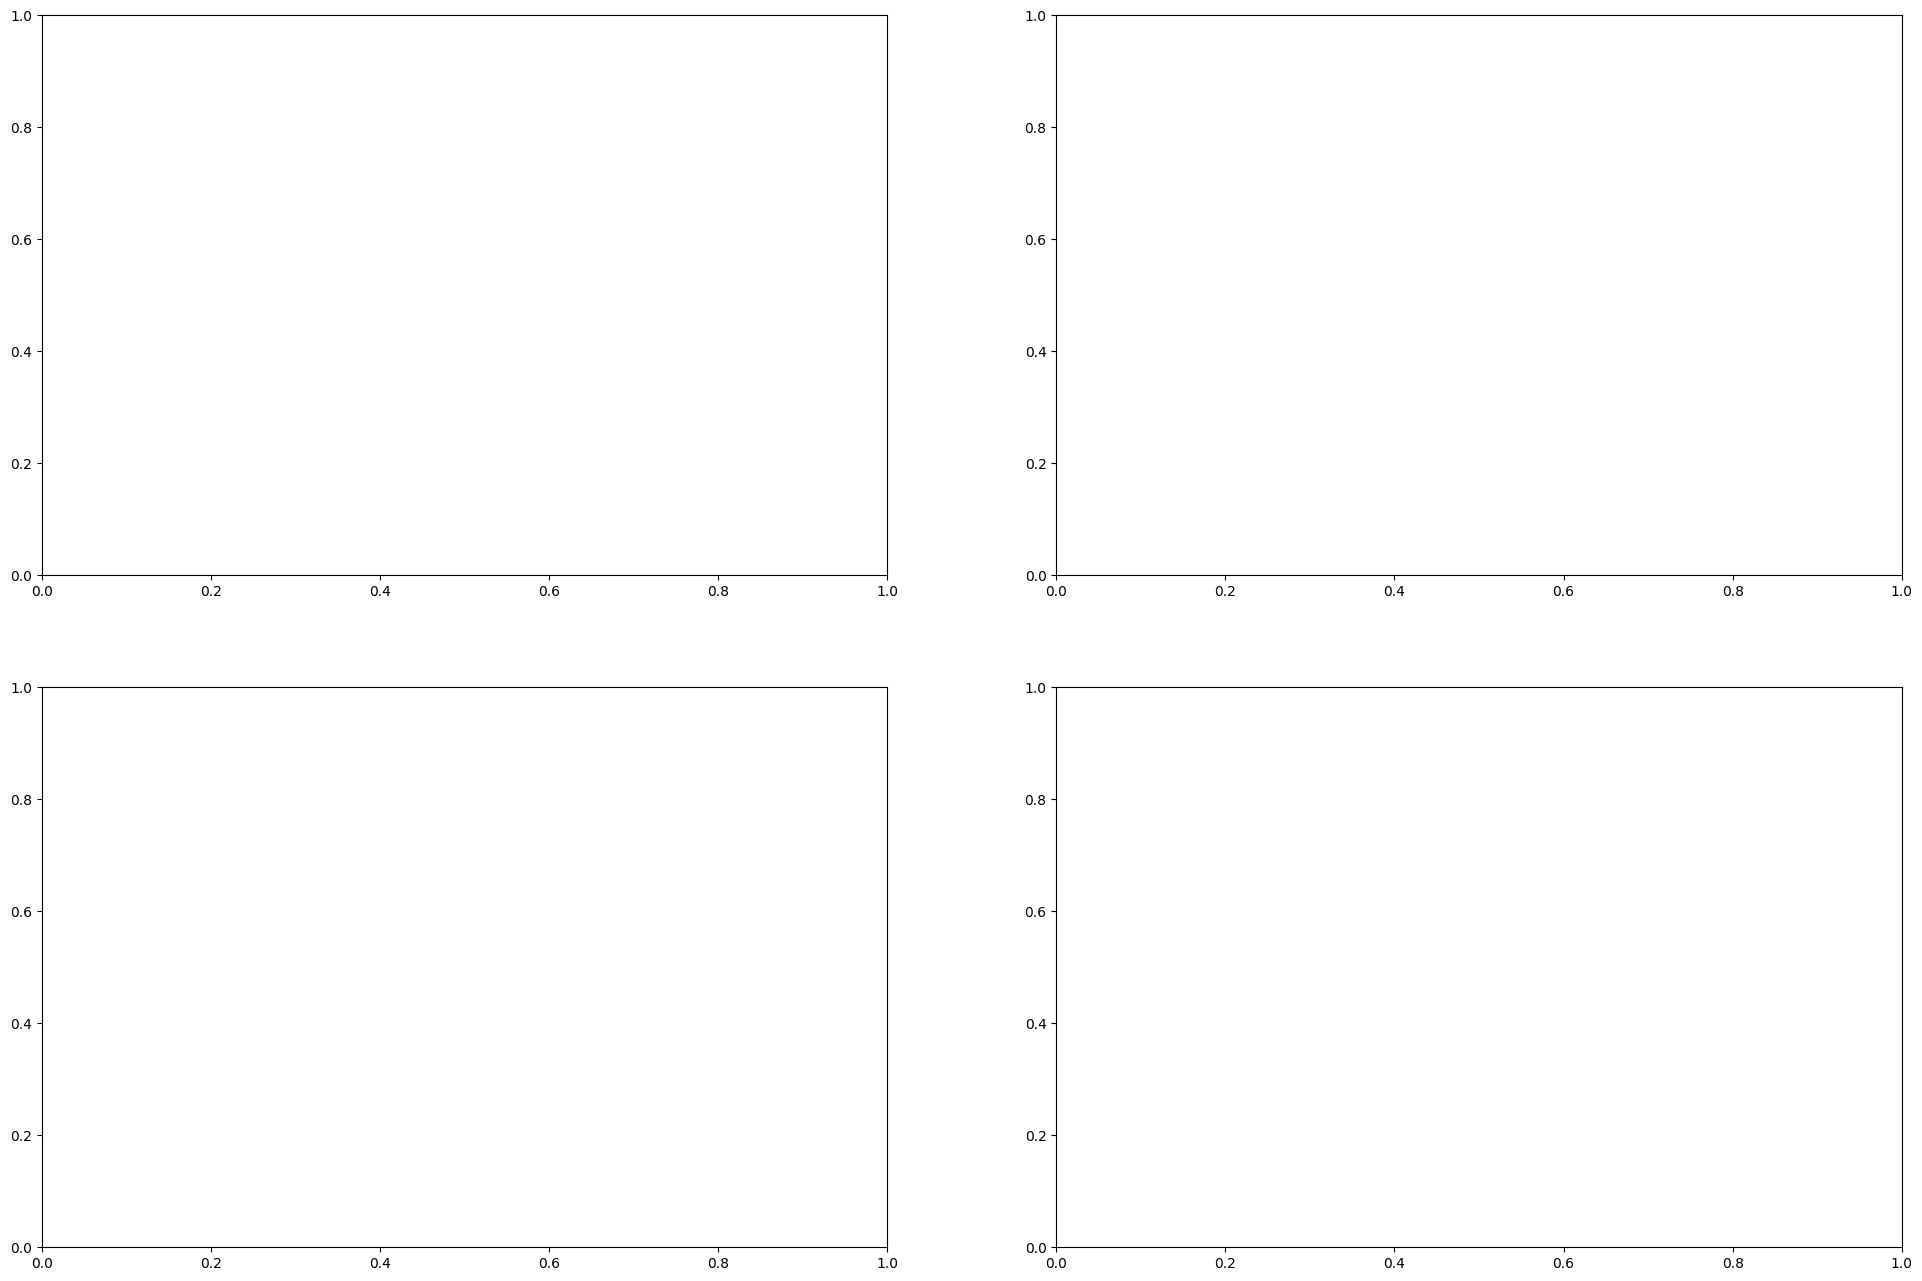

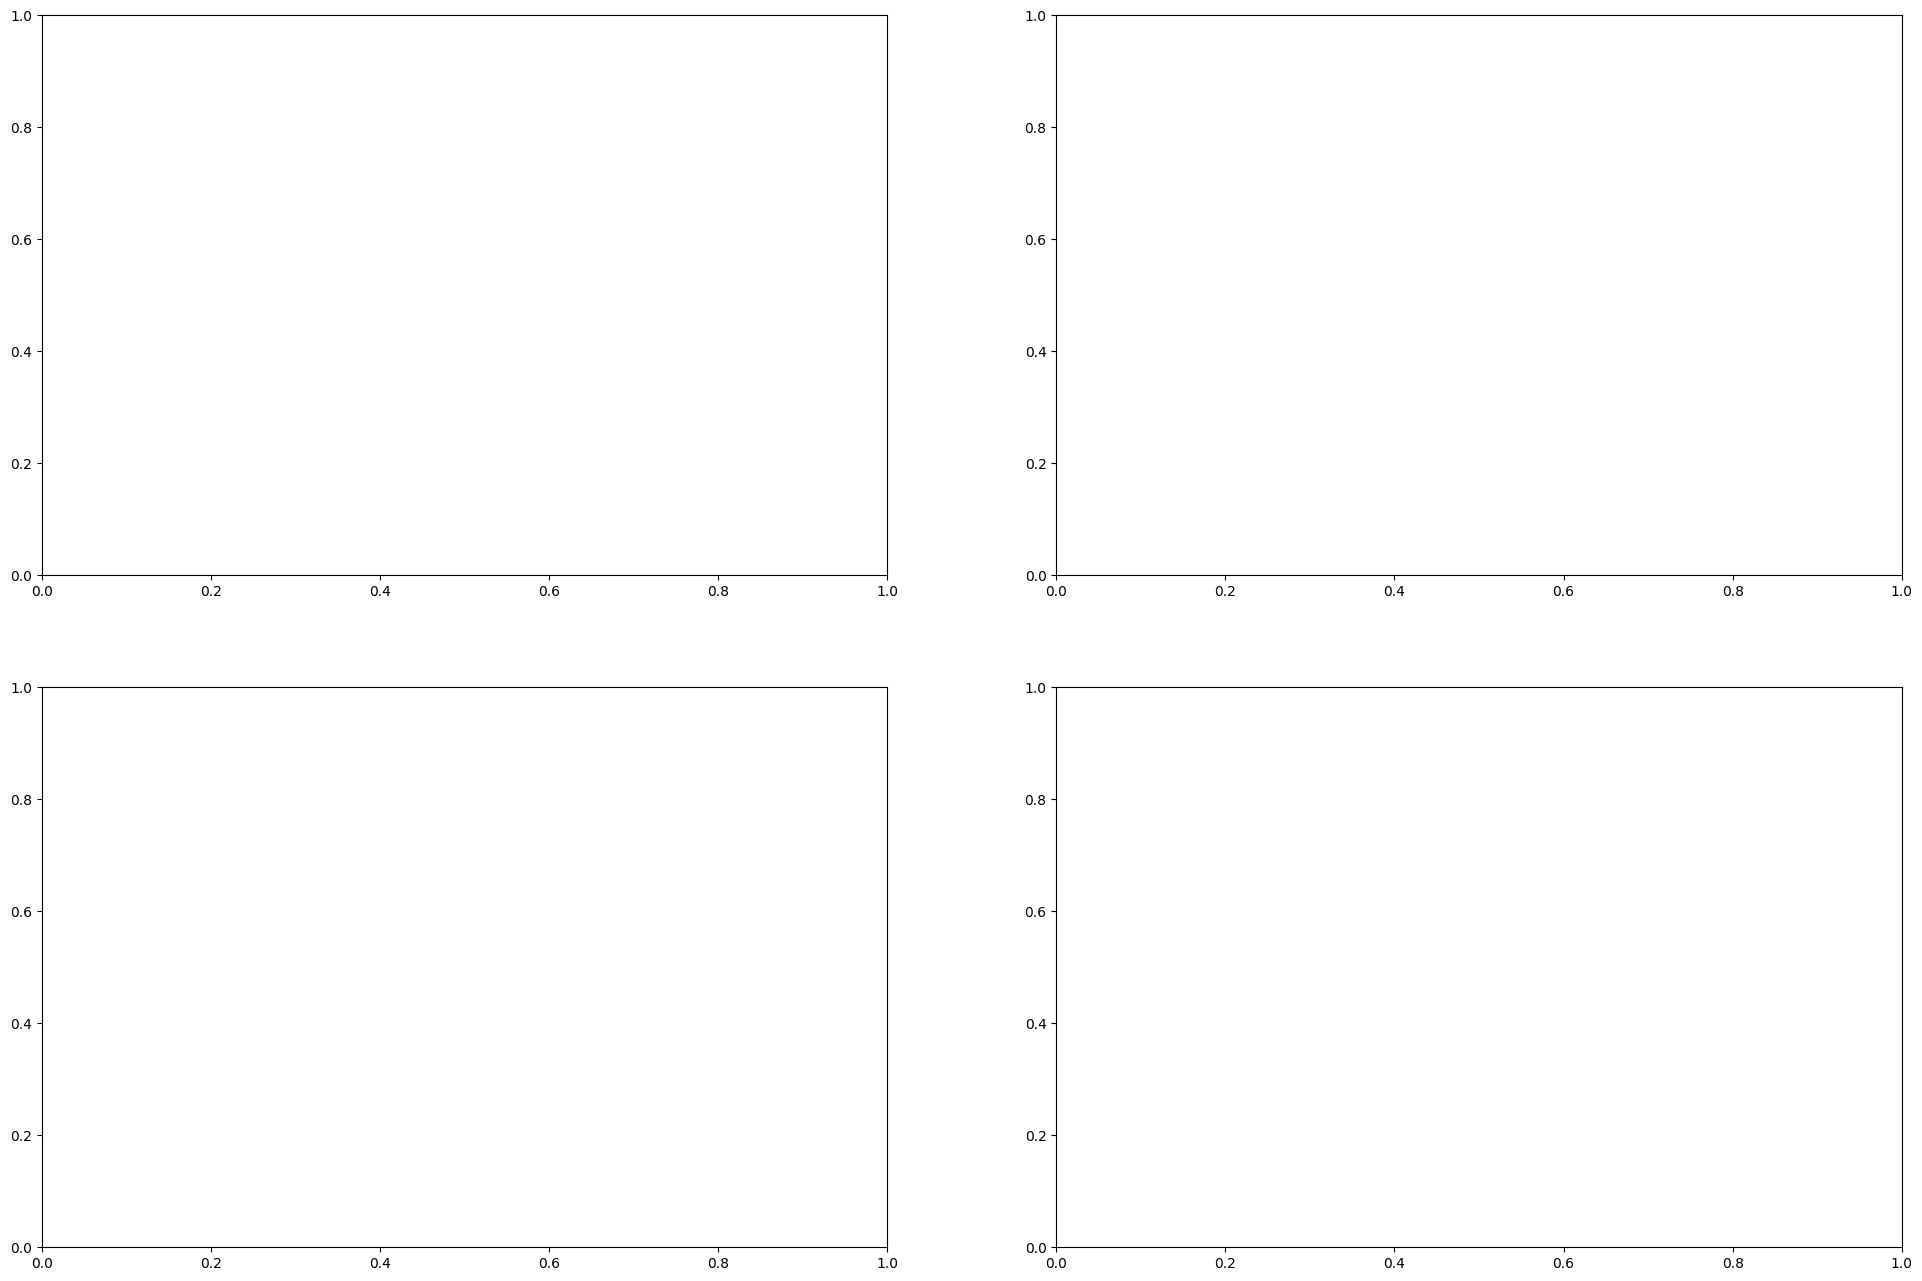

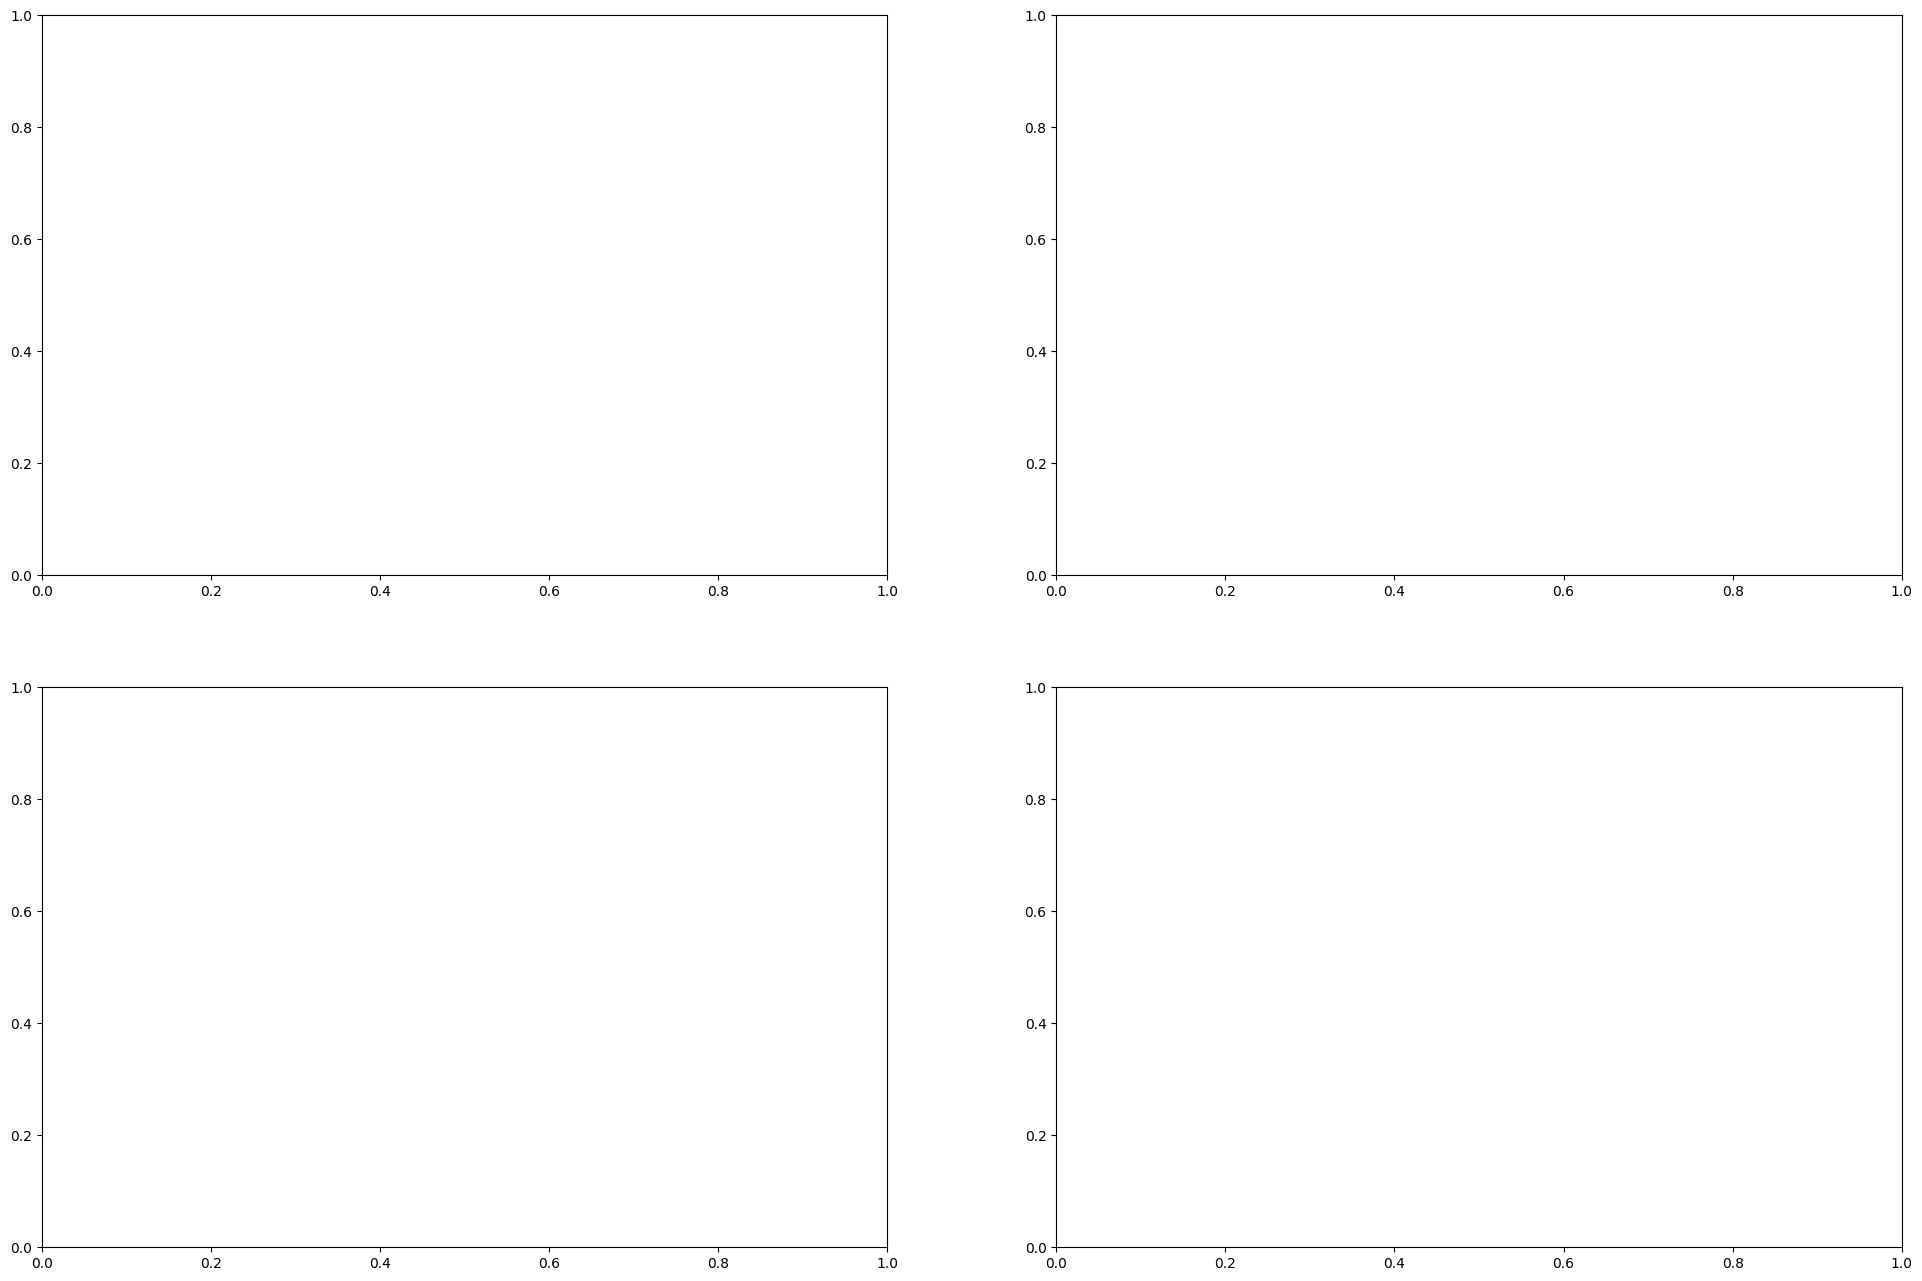

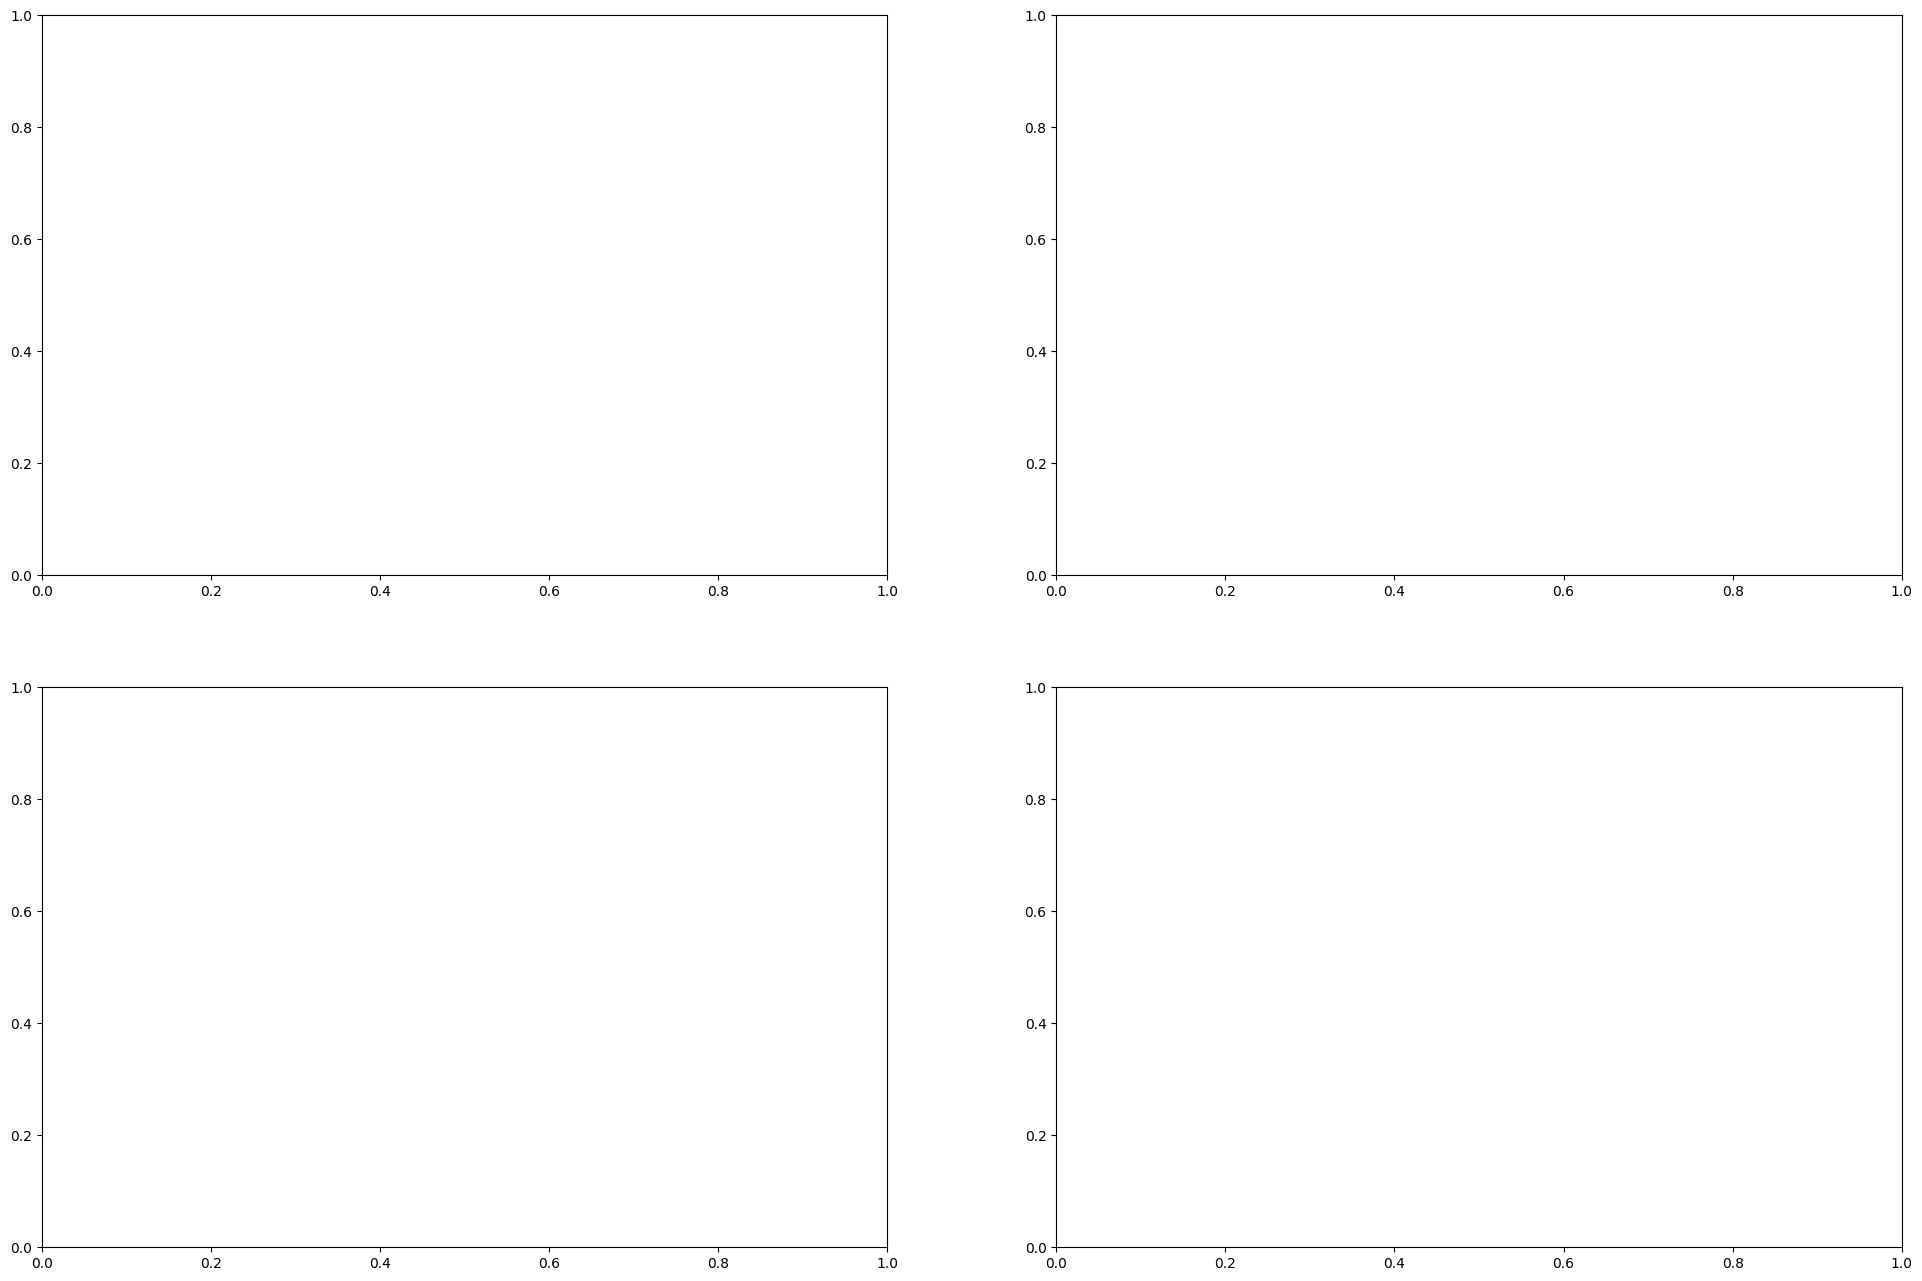

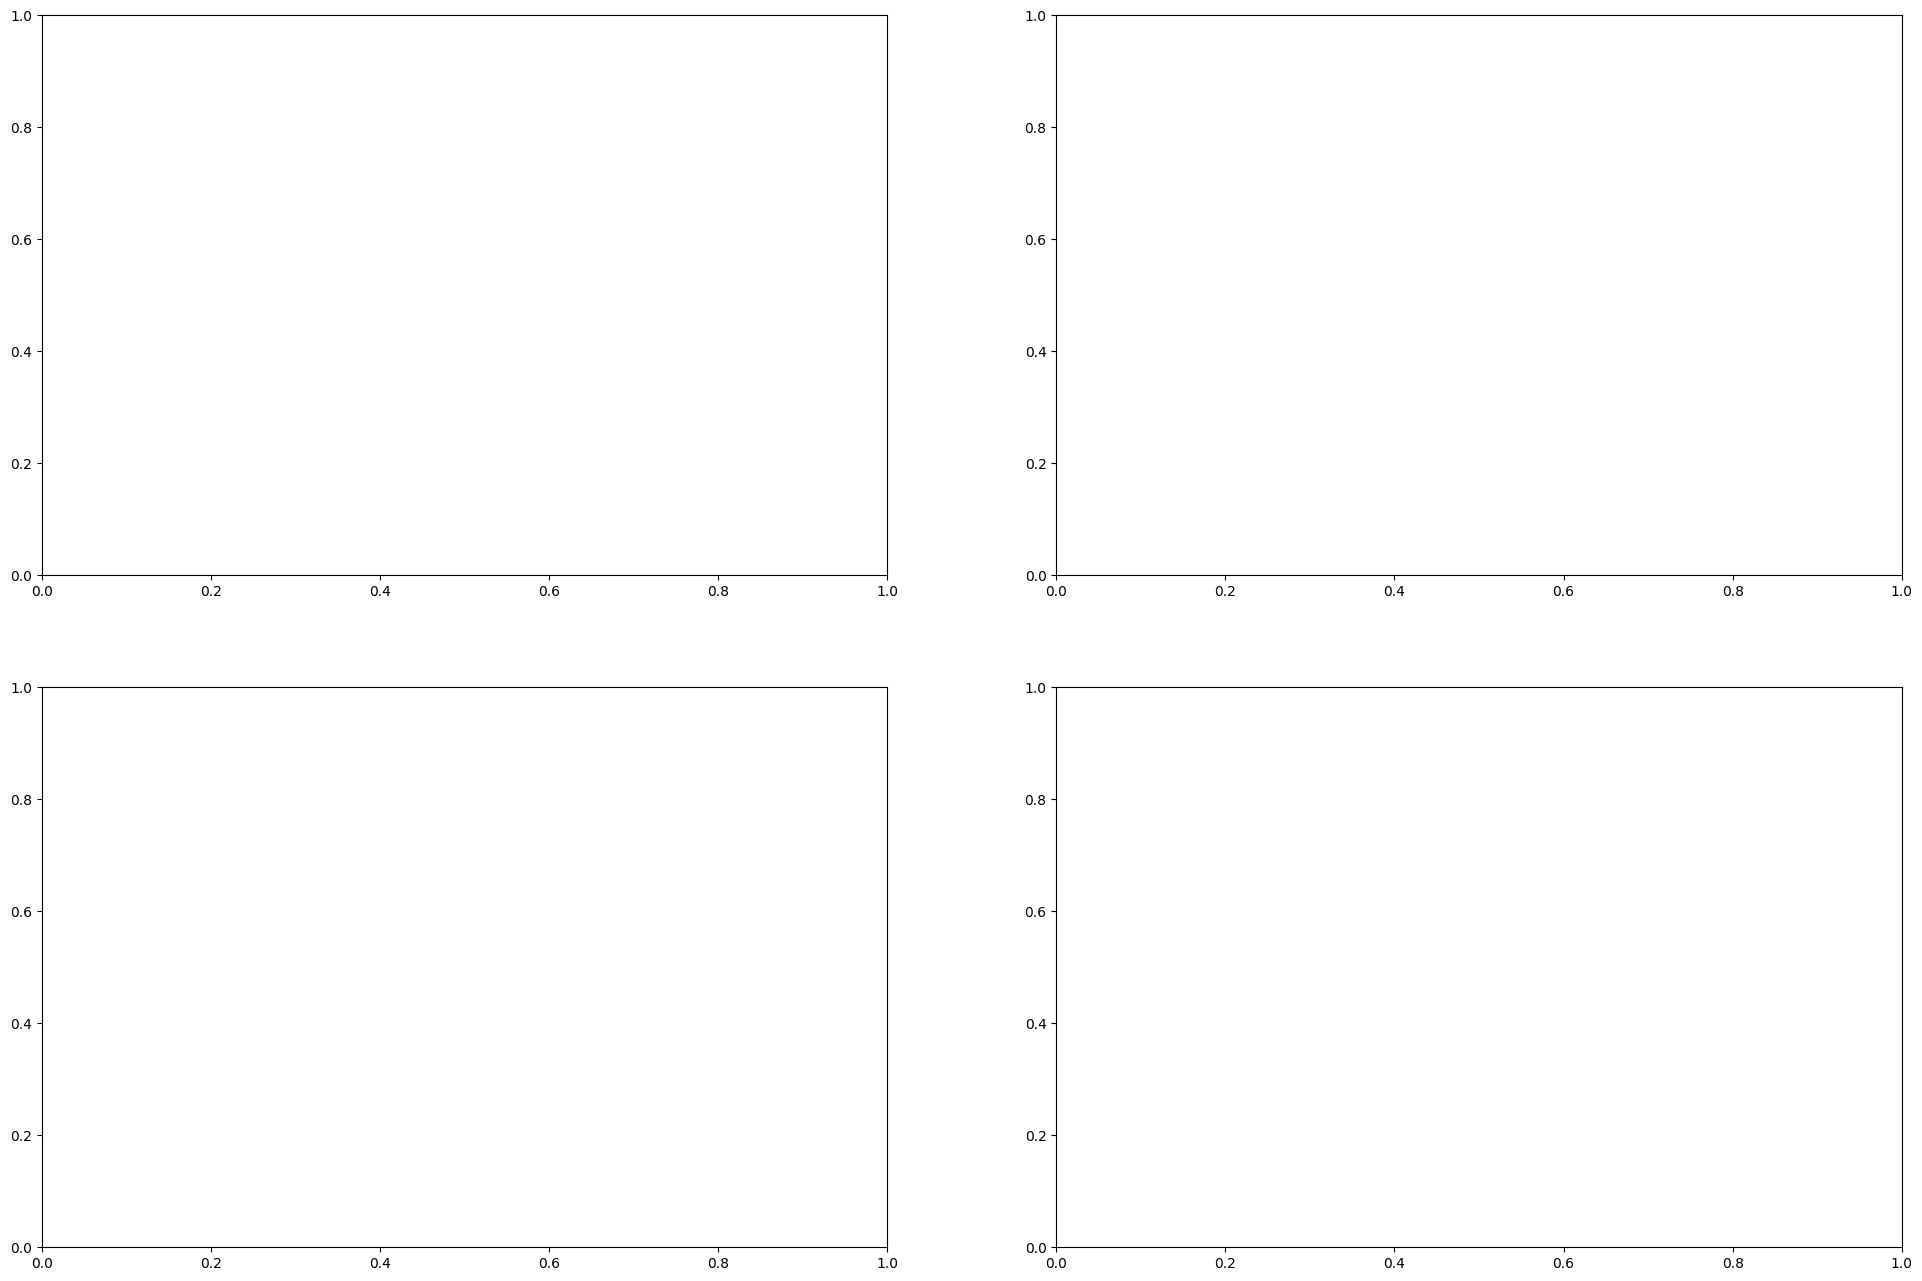

In [7]:
#@markdown  Run this cell to generate summary summary

import json
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from pathlib import Path
import argparse
from matplotlib.table import Table
from matplotlib.gridspec import GridSpec

def load_data_from_json(json_path):
    """
    Load chain iptm data and other metrics from a JSON file.

    Parameters:
    - json_path: str, path to the JSON file.

    Returns:
    - chain_iptm_data: 2D NumPy array of chain iptm values.
    - metrics: Dictionary containing the values for "fraction_disordered", "has_clash",
               "iptm", "num_recycles", "ptm", and "ranking_score".
    """
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)

        chain__pair_iptm_data = np.array(data['chain_pair_iptm'])
        chain_pair_pae_min_data = np.array(data['chain_pair_pae_min'])
        chain_iptm_data = np.array(data['chain_iptm'])
        chain_ptm_data = np.array(data['chain_ptm'])

        metrics = {
            "fraction_disordered": data.get("fraction_disordered"),
            "has_clash": data.get("has_clash"),
            "iptm": data.get("iptm"),
            "num_recycles": data.get("num_recycles"),
            "ptm": data.get("ptm"),
            "ranking_score": data.get("ranking_score")
        }
        return chain__pair_iptm_data, metrics, chain_pair_pae_min_data, chain_iptm_data, chain_ptm_data
    except (FileNotFoundError, json.JSONDecodeError, KeyError) as e:
        print(f"Error loading JSON file: {e}")
        return None, None



def plot_heatmap_with_table(data1, data2, data3, data4, labels, metrics, output_dir, json_file_name):
    """
    Plot two heatmaps and two linear heatmaps with different plot heights.

    Parameters:
    - data1: 2D NumPy array for the first heatmap.
    - data2: 2D NumPy array for the second heatmap.
    - data3: 1D NumPy array for the third heatmap (horizontal).
    - data4: 1D NumPy array for the fourth heatmap (horizontal).
    - labels: List of labels for the heatmap axes.
    - metrics: Dictionary containing additional metrics.
    """
    # Create a figure with GridSpec
    fig = plt.figure(figsize=(26, 18))
    spec = GridSpec(4, 4, figure=fig, height_ratios=[2, 0.2, 0.2, 0.4])  # Adjusted for more space below

    # Define axes
    ax1 = fig.add_subplot(spec[0, 0:2])  # Top-left: spans 2 columns
    ax2 = fig.add_subplot(spec[0, 2:4])  # Top-right: spans 2 columns
    ax3 = fig.add_subplot(spec[1, 1:3])  # Bottom-left: smaller and centered
    ax4 = fig.add_subplot(spec[2, 1:3])  # Bottom-right: smaller and centered
    ax_table = fig.add_subplot(spec[3, 1:3])  # Space for the table below

    # Plot first heatmap
    sns.heatmap(data1, annot=True, cmap="Blues", xticklabels=labels, yticklabels=labels,
                cbar_kws={'label': 'iptm Score'}, vmin=0, vmax=1, ax=ax1)
    ax1.set_title("Chain Pair IPTM Heatmap")
    ax1.set_xlabel("Chain Labels")
    ax1.set_ylabel("Chain Labels")
    ax1.xaxis.set_ticks_position('top')

    # Plot second heatmap
    sns.heatmap(data2, annot=True, cmap="Greens_r", xticklabels=labels, yticklabels=labels,
                cbar_kws={'label': 'PAE Score'}, vmin=0, vmax=32, ax=ax2)
    ax2.set_title("Chain Pair PAE Heatmap")
    ax2.set_xlabel("Chain Labels")
    ax2.set_ylabel("Chain Labels")
    ax2.xaxis.set_ticks_position('top')

    # Plot third heatmap
    im = sns.heatmap(np.array(data3).reshape(1, -1), annot=True, cmap="coolwarm_r", xticklabels=labels, cbar = False,
                     cbar_kws={'label': 'Chain iptm'}, vmin=0, vmax=1, ax=ax3)
    ax3.set_title("Heatmap of chain iptm")
    ax3.set_yticks([])  # Remove y-axis ticks for linear data

    # Plot fourth heatmap
    sns.heatmap(np.array(data4).reshape(1, -1), annot=True, cmap="coolwarm_r", xticklabels=labels, cbar = False,
                cbar_kws={'label': 'Chain ptm'}, vmin=0, vmax=1, ax=ax4)
    ax4.set_title("Heatmap of chain ptm")
    ax4.set_yticks([])  # Remove y-axis ticks for linear data

    # Colorbar for third and fourth heatmaps
    mappable = im.get_children()[0]
    plt.colorbar(mappable, ax=[ax3, ax4], orientation='horizontal')

    # Add table
    ax_table.axis('off')  # Turn off the axis for the table
    table = Table(ax_table, bbox=[0, 0, 1, 1])  # Adjust bbox to fit the table within the axis

    table.auto_set_column_width([0.5, 0.5])
    # Display additional metrics as a table
    # Add rows to the table
    for i, (key, value) in enumerate(metrics.items()):
        table.add_cell(i, 0, 0.2, 0.3, text=key, loc='center', edgecolor='black', facecolor='lightgray')
        table.add_cell(i, 1, 0.2, 0.3, text=value, loc='center', edgecolor='black')

    # Add header row
    table.add_cell(-1, 0, 0.2, 0.3, text="Metric", loc='center', edgecolor='black', facecolor='lightblue')
    table.add_cell(-1, 1, 0.2, 0.3, text="Value", loc='center', edgecolor='black', facecolor='lightblue')

    ax_table.add_table(table)

        # Save the plot
    output_file = Path(output_dir) / f"{json_file_name}_summary.png"
    plt.savefig(output_file, bbox_inches='tight')
    plt.close()
    print(f"Combined plot saved to {output_file}")


def process_folder(folder_path, output_dir):
    """
    Process all JSON files in the folder matching the pattern *summary_confidences_*.json.

    Parameters:
    - folder_path: str, path to the folder containing JSON files.
    - output_dir: str, path to save the plots.
    """
    json_files = glob.glob(f"{folder_path}/*summary_confidences_*.json")
    if not json_files:
        print(f"No matching JSON files found in folder: {folder_path}")
        return

    # Create the output directory if it doesn't exist
    Path(output_dir).mkdir(parents=True, exist_ok=True)

    for json_file in json_files:
        json_file_name = Path(json_file).stem
        print(f"Processing file: {json_file}")
        chain__pair_iptm_data, metrics, chain_pair_pae_min_data, chain_iptm_data, chain_ptm_data = load_data_from_json(json_file)

        if chain__pair_iptm_data is not None:
            # Create labels for the columns (alphabetical order starting with 'A')
            labels = [chr(i) for i in range(65, 65 + chain__pair_iptm_data.shape[1])]

            Path(output_dir).mkdir(parents=True, exist_ok=True)
            fig, axes = plt.subplots(2, 2, figsize=(24, 16))
            (ax1, ax2), (ax3, ax4) = axes

            plot_heatmap_with_table(chain__pair_iptm_data, chain_pair_pae_min_data, chain_iptm_data,chain_ptm_data, labels, metrics, output_dir, json_file_name)

        else:
            print(f"Skipping file due to error: {json_file}")



def main():
    json_file_path = "/content/unzipped_files"  # Replace with your JSON file path
    output_dir = "/content/outputs/"   # Replace with your desired PDF file path

    # Process all matching JSON files in the folder
    process_folder(json_file_path, output_dir)


main()


In [8]:
#@markdown  Run this cell to download all plots in a zip file
import os
import zipfile
from google.colab import files  # Ensure you're importing this
import shutil

# Define the zip filename and output directory
zip_filename = "af_server_reports.zip"
output = "/content/outputs"

# Zip the extracted files
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, docs in os.walk(output):
        for file in docs:
            file_path = os.path.join(root, file)
            # Write file to the zip archive, maintaining directory structure
            zipf.write(file_path, os.path.relpath(file_path, output))
            os.remove(file_path)

# Notify that the zip file has been created
print(f"Created zip archive: {zip_filename}")

# Download the zip file
files.download(zip_filename)  # This should work now

Created zip archive: af_server_reports.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>